In [1]:
import os
import pandas as pd
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import IPython 
import torch 

import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def read(f, normalized=False):
    """WAV to numpy array"""
    a = AudioSegment.from_wav(f)
    a = a.set_frame_rate(48000)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    
output_paths = pd.read_csv('output_paths.csv')
output_paths = output_paths['0'].to_list()

In [10]:
from msclap import CLAP

# Load and initialize CLAP
clap_model = CLAP(version = 'clapcap', use_cuda=False)

#Load audio files
#audio_files = output_paths[:3]
audio_files = []

audio_files.append('\\'.join(output_paths[1].split('\\')[:-2] + ['boi - Bass.wav']))
audio_files.append('\\'.join(output_paths[10].split('\\')[:-2] + ['c harm minor dummy - Bass.wav']))
audio_files.append(output_paths[10])
audio_files.append(output_paths[11])
audio_files.append(output_paths[12])
audio_files.append(output_paths[13])

# Generate captions for the recording
captions, emb, audio_outs = clap_model.generate_caption(audio_files, beam_size  = 5, temperature = 0.5)

# Print the result
for i in range(len(audio_files)):
    print(f"Audio file: {audio_files[i]} \n")
    print(f"Generated caption: {captions[i]} \n")

Audio file: D:\Phd\Phd Dummy audio\Boi\boi - Bass.wav 

Generated caption: A beat is played continuously and then a beat is played.  

Audio file: D:\Phd\Phd Dummy audio\C harmonic minor\c harm minor dummy - Bass.wav 

Generated caption: A synthesizer is playing a synthesizer.  

Audio file: D:\Phd\Phd Dummy audio\C harmonic minor\output\output_Bass_KickSnare.wav 

Generated caption: A beat is played with a beat and a beat.  

Audio file: D:\Phd\Phd Dummy audio\C harmonic minor\output\output_Bass_Perc.wav 

Generated caption: A synthesizer plays a synthesizer with a beat.  

Audio file: D:\Phd\Phd Dummy audio\C harmonic minor\output\output_Bass_Piano.wav 

Generated caption: A synthesizer is playing a synthesizer.  

Audio file: D:\Phd\Phd Dummy audio\C harmonic minor\output\output_Bass_Synth.wav 

Generated caption: A synthesizer is playing a synthesizer.  



In [26]:
song_list = []
song_emb = []

for i in range(len(audio_files)):
    song_list.append(audio_files[i].split('\\')[-1])
    song_emb.append(emb[i,:,:])

In [34]:
song_emb[0].shape

torch.Size([40, 768])

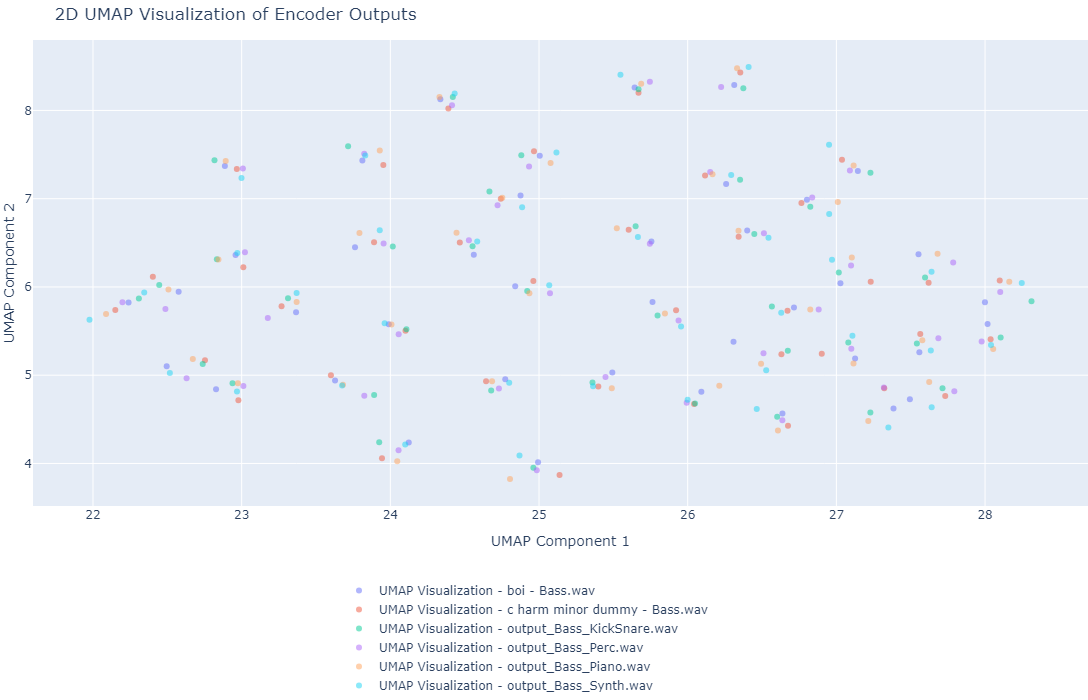

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_umap(embeddings_list, song_names):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]])

    # Concatenate all embeddings into a single array
    all_embeddings = np.concatenate([emb.cpu().numpy() for emb in embeddings_list])

    reducer = umap.UMAP(n_neighbors=700, random_state=42, n_components=2)

    # Apply UMAP to reduce the dimensionality to 2D for all embeddings
    umap_result = reducer.fit_transform(all_embeddings)

    # Plot each song's UMAP visualization separately
    start_index = 0
    for i, (encoder_outputs_tensor, song_name) in enumerate(zip(embeddings_list, song_names)):
        num_points = encoder_outputs_tensor.size(0)
        end_index = start_index + num_points

        scatter_trace = go.Scatter(
            x=umap_result[start_index:end_index, 0],
            y=umap_result[start_index:end_index, 1],
            mode='markers',
            marker=dict(opacity=0.5, colorscale='Viridis'),
            name=f'UMAP Visualization - {song_name}'
        )

        fig.add_trace(scatter_trace)

        start_index = end_index

    fig.update_layout(
        xaxis=dict(title='UMAP Component 1'),
        yaxis=dict(title='UMAP Component 2'),
        title='2D UMAP Visualization of Encoder Outputs',
        legend=dict(orientation='h', x=0.5, y=-0.15),
        height=700,
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.show()
plot_umap(song_emb, song_list)

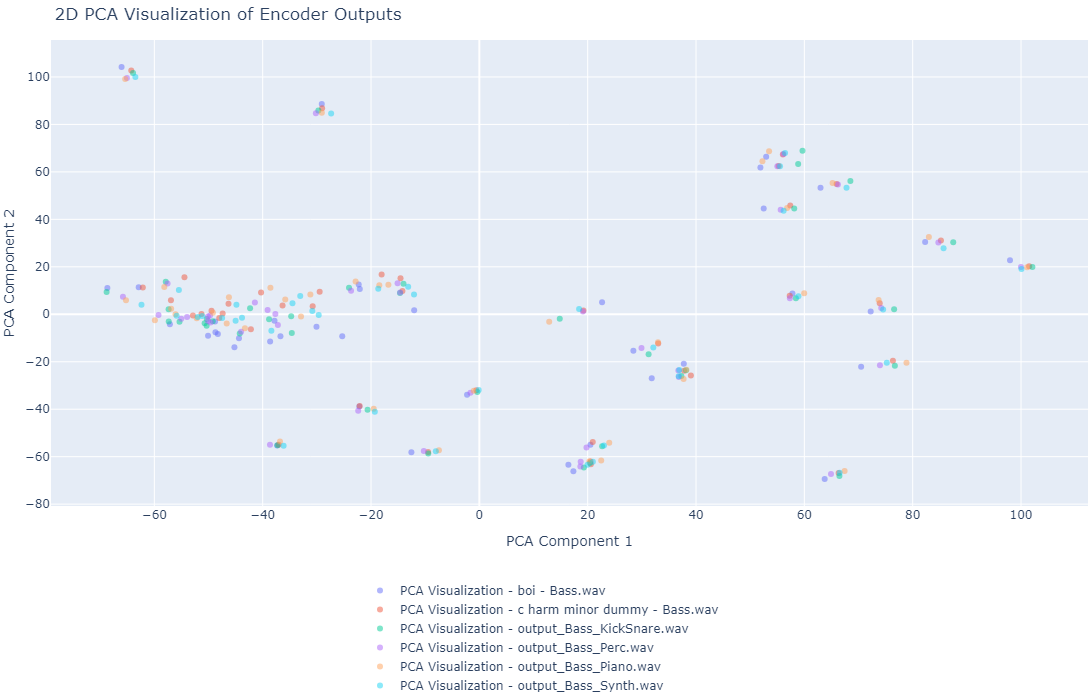

In [44]:
from sklearn.decomposition import PCA

def plot_pca(embeddings_list, song_names):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter'}]])

    # Concatenate all embeddings into a single array
    all_embeddings = np.concatenate([emb.cpu().numpy() for emb in embeddings_list])

    # Apply PCA to reduce the dimensionality to 2D for all embeddings
    pca_result = PCA(n_components=2).fit_transform(all_embeddings)

    # Plot each song's PCA visualization separately
    start_index = 0
    for i, (encoder_outputs_tensor, song_name) in enumerate(zip(embeddings_list, song_names)):
        num_points = encoder_outputs_tensor.size(0)
        end_index = start_index + num_points

        scatter_trace = go.Scatter(
            x=pca_result[start_index:end_index, 0],
            y=pca_result[start_index:end_index, 1],
            mode='markers',
            marker=dict(opacity=0.5, colorscale='Viridis'),
            name=f'PCA Visualization - {song_name}'
        )

        fig.add_trace(scatter_trace)

        start_index = end_index

    fig.update_layout(
        xaxis=dict(title='PCA Component 1'),
        yaxis=dict(title='PCA Component 2'),
        title='2D PCA Visualization of Encoder Outputs',
        legend=dict(orientation='h', x=0.5, y=-0.15),
        height=700,
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.show()
    
plot_pca(song_emb, song_list)

In [ ]:
from transformers import ClapModel, ClapProcessor

sr, audio_sample = read(output_paths[0])

model = ClapModel.from_pretrained("laion/larger_clap_music")
processor = ClapProcessor.from_pretrained("laion/larger_clap_music")

inputs = processor(audios=audio_sample, return_tensors="pt", sampling_rate = sr)
audio_embed = model.get_audio_features(**inputs)

In [ ]:
audio_sample